In [62]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

In [63]:
# 检查是否有可用的GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [64]:
def get_MNIST_data():
    train_data = torchvision.datasets.MNIST(root='./Datasets/MNIST', transform=transforms.ToTensor(), train=True, download=True)
    test_data = torchvision.datasets.MNIST(root='./Datasets/MNIST', transform=transforms.ToTensor(), train=False, download=True)
    
    return train_data, test_data

In [65]:
def draw_loss(train_loss, test_loss):
    x = np.linspace(0, len(train_loss), len(train_loss))
    plt.plot(x, train_loss, label="Train Loss", linewidth=1.5)
    plt.plot(x, test_loss, label="Test Loss", linewidth=1.5)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [66]:
def evaluate_accuracy(data_iter, model, loss_func):
    acc_sum, test_1_sum, n, c = 0.0, 0.0, 0, 0
    model.eval()  # 切换到评估模式
    with torch.no_grad():  # 禁用梯度计算
        for X, y in data_iter:
            X, y = X.to(device), y.to(device)  # 将数据移动到GPU
            result = model.forward(X)
            acc_sum += (result.argmax(dim=1) == y).float().sum().item()
            test_1_sum += loss_func(result, y).item()
            n += y.shape[0]
            c += 1
    model.train()  # 切换回训练模式
    return acc_sum / n, test_1_sum / c

In [67]:
class MyDataset(Dataset):
    def __init__(self, X, y, task_type='regression'):
        self.X = torch.tensor(X, dtype=torch.float32)
        if task_type == 'classification':
            self.y = torch.tensor(y, dtype=torch.long)
        else:
            self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [68]:
# 准备数据
train_data, test_data = get_MNIST_data()
batch_size = 256

train_dataset = MyDataset(train_data.data, train_data.targets, task_type='classification')
test_dataset = MyDataset(test_data.data, test_data.targets, task_type='classification')

train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_iter = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

C:\Users\Jemzh\AppData\Local\Temp\ipykernel_19596\410304132.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X, dtype=torch.float32)
C:\Users\Jemzh\AppData\Local\Temp\ipykernel_19596\410304132.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.long)


In [69]:
# 定义模型
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 定义模型参数
        num_inputs, num_outputs, num_hiddens = 784, 10, 256
        
        # 定义模型结构
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_inputs, num_hiddens),
            nn.ReLU(),
            nn.Linear(num_hiddens, num_outputs),
        )
        
        # 初始化模型参数
        for layer in self.model.parameters():
            nn.init.normal_(layer, mean=0, std=0.01)
    
    def forward(self, x):
        x = self.model(x)
        x = torch.softmax(x, dim=1)
        return x

In [70]:
# 定义训练函数
def train(net, train_iter, loss_func, num_epochs, lr=None, optimizer=None):
    train_loss_list = []
    test_loss_list = []
    net.to(device)
    for epoch in range(num_epochs):
        train_1_sum, train_acc_sum, n, c = 0.0, 0.0, 0, 0
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            loss = loss_func(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_1_sum += loss.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
            c += 1
        test_acc, test_loss = evaluate_accuracy(test_iter, net, loss_func)
        train_loss_list.append(train_1_sum / c)
        test_loss_list.append(test_loss)
        print('epoch %d, train loss %.4f, test loss %.4f, train acc %.3f, test acc %.3f' % (epoch + 1, train_1_sum / c, test_loss, train_acc_sum / n, test_acc))
    return train_loss_list, test_loss_list

epoch 1, train loss 1.7427, test loss 1.6252, train acc 0.721, test acc 0.838
epoch 2, train loss 1.6155, test loss 1.6045, train acc 0.848, test acc 0.856
epoch 3, train loss 1.6014, test loss 1.6103, train acc 0.862, test acc 0.852
epoch 4, train loss 1.5937, test loss 1.5956, train acc 0.868, test acc 0.866
epoch 5, train loss 1.5148, test loss 1.5013, train acc 0.951, test acc 0.962
epoch 6, train loss 1.4920, test loss 1.4942, train acc 0.973, test acc 0.970
epoch 7, train loss 1.4874, test loss 1.4969, train acc 0.977, test acc 0.966
epoch 8, train loss 1.4839, test loss 1.4931, train acc 0.981, test acc 0.970
epoch 9, train loss 1.4810, test loss 1.4898, train acc 0.983, test acc 0.973
epoch 10, train loss 1.4793, test loss 1.4915, train acc 0.985, test acc 0.971
epoch 11, train loss 1.4774, test loss 1.4892, train acc 0.986, test acc 0.973
epoch 12, train loss 1.4762, test loss 1.4868, train acc 0.987, test acc 0.976
epoch 13, train loss 1.4748, test loss 1.4898, train acc 0.98

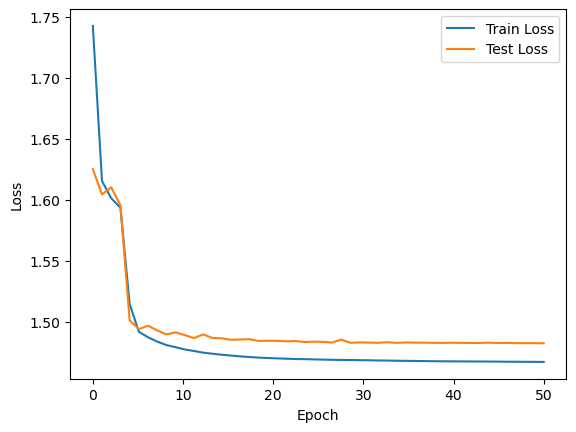

In [71]:
# 训练模型
## 初始化模型
net = Net()
## 设置训练轮数
num_epochs = 50
## 设置学习率
lr = 0.01
## 指定优化器为PyTorch自带的随机梯度下降
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
## 初始化损失函数
loss = nn.CrossEntropyLoss()

# 开始训练
train_loss, test_loss = train(net, train_iter, loss, num_epochs, lr, optimizer)
# 训练完成后绘制损失函数
draw_loss(train_loss, test_loss)

Task 3: 在多分类任务中使用至少三种不同的激活函数，进行对比实验并分析实验结果

In [26]:
# 定义模型
class Net(nn.Module):
    def __init__(self, activation):
        super(Net, self).__init__()
        # 定义模型参数
        num_inputs, num_outputs, num_hiddens = 784, 10, 256
        
        # 定义模型结构
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_inputs, num_hiddens),
            activation,
            nn.Linear(num_hiddens, num_outputs),
        )
        
        # 初始化模型参数
        for layer in self.model.parameters():
            nn.init.normal_(layer, mean=0, std=0.01)
    
    def forward(self, x):
        x = self.model(x)
        x = torch.softmax(x, dim=1)
        return x

epoch 1, train loss 1.7388, test loss 1.6194, train acc 0.726, test acc 0.844
epoch 2, train loss 1.6148, test loss 1.6748, train acc 0.850, test acc 0.788
epoch 3, train loss 1.5932, test loss 1.5129, train acc 0.870, test acc 0.952
epoch 4, train loss 1.5025, test loss 1.5129, train acc 0.963, test acc 0.952
epoch 5, train loss 1.4949, test loss 1.4973, train acc 0.970, test acc 0.967
epoch 6, train loss 1.4902, test loss 1.5003, train acc 0.975, test acc 0.963
epoch 7, train loss 1.4866, test loss 1.4956, train acc 0.978, test acc 0.968
epoch 8, train loss 1.4840, test loss 1.4927, train acc 0.980, test acc 0.969
epoch 9, train loss 1.4817, test loss 1.4935, train acc 0.982, test acc 0.970
epoch 10, train loss 1.4798, test loss 1.4888, train acc 0.984, test acc 0.974
epoch 11, train loss 1.4783, test loss 1.4927, train acc 0.985, test acc 0.970
epoch 12, train loss 1.4768, test loss 1.4915, train acc 0.987, test acc 0.971
epoch 13, train loss 1.4756, test loss 1.4882, train acc 0.98

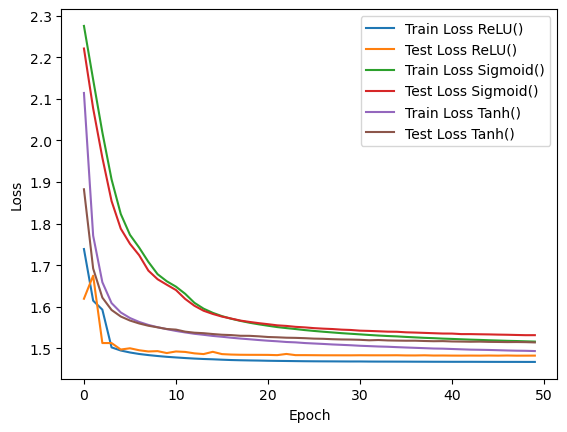

In [27]:
# 训练模型
## 初始化模型
activation_list = [nn.ReLU(), nn.Sigmoid(), nn.Tanh()]
train_loss_list = []
test_loss_list = []
for activation in activation_list:
    net = Net(activation)
    ## 设置训练轮数
    num_epochs = 50
    ## 设置学习率
    lr = 0.01
    ## 指定优化器为PyTorch自带的随机梯度下降
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    ## 初始化损失函数
    loss = nn.CrossEntropyLoss()

    # 开始训练
    train_loss, test_loss = train(net, train_iter, loss, num_epochs, lr, optimizer)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    
# 训练完成后将损失函数绘制在同一张图上
for i in range(len(activation_list)):
    plt.plot(train_loss_list[i], label="Train Loss " + str(activation_list[i]))
    plt.plot(test_loss_list[i], label="Test Loss " + str(activation_list[i]))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Task 4: 对多分类任务中的模型评估隐藏层层数和隐藏单元个数对实验结果的影响

In [42]:
# 定义模型
class Net0(nn.Module):
    def __init__(self):
        super(Net0, self).__init__()
        # 定义模型参数
        num_inputs, num_outputs, num_hiddens = 784, 10, 256

        # 定义模型结构
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_inputs, num_hiddens),
            nn.ReLU(),
            nn.Linear(num_hiddens, num_outputs),
        )

        # 初始化模型参数
        for layer in self.model.parameters():
            nn.init.normal_(layer, mean=0, std=0.01)

    def forward(self, x):
        x = self.model(x)
        x = torch.softmax(x, dim=1)
        return x

In [43]:
# 定义模型
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        # 定义模型参数
        num_inputs, num_outputs, num_hiddens = 784, 10, 256

        # 定义模型结构
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_inputs, num_hiddens),
            nn.ReLU(),
            nn.Linear(num_hiddens, num_hiddens),
            nn.ReLU(),
            nn.Linear(num_hiddens, num_outputs),
        )

        # 初始化模型参数
        for layer in self.model.parameters():
            nn.init.normal_(layer, mean=0, std=0.01)

    def forward(self, x):
        x = self.model(x)
        x = torch.softmax(x, dim=1)
        return x

In [44]:
# 定义模型
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        # 定义模型参数
        num_inputs, num_outputs, num_hiddens = 784, 10, 256

        # 定义模型结构
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_inputs, num_hiddens),
            nn.ReLU(),
            nn.Linear(num_hiddens, num_hiddens),
            nn.ReLU(),
            nn.Linear(num_hiddens, num_hiddens),
            nn.ReLU(),
            nn.Linear(num_hiddens, num_outputs),
        )

        # 初始化模型参数
        for layer in self.model.parameters():
            nn.init.normal_(layer, mean=0, std=0.01)

    def forward(self, x):
        x = self.model(x)
        x = torch.softmax(x, dim=1)
        return x

In [45]:
# 定义模型
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        # 定义模型参数
        num_inputs, num_outputs, num_hiddens = 784, 10, 512

        # 定义模型结构
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_inputs, num_hiddens),
            nn.ReLU(),
            nn.Linear(num_hiddens, num_outputs),
        )

        # 初始化模型参数
        for layer in self.model.parameters():
            nn.init.normal_(layer, mean=0, std=0.01)

    def forward(self, x):
        x = self.model(x)
        x = torch.softmax(x, dim=1)
        return x

In [46]:
# 定义模型
class Net4(nn.Module):
    def __init__(self):
        super(Net4, self).__init__()
        # 定义模型参数
        num_inputs, num_outputs, num_hiddens = 784, 10, 512

        # 定义模型结构
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_inputs, num_hiddens),
            nn.ReLU(),
            nn.Linear(num_hiddens, num_hiddens),
            nn.ReLU(),
            nn.Linear(num_hiddens, num_outputs),
        )

        # 初始化模型参数
        for layer in self.model.parameters():
            nn.init.normal_(layer, mean=0, std=0.01)

    def forward(self, x):
        x = self.model(x)
        x = torch.softmax(x, dim=1)
        return x

In [47]:
# 定义模型
class Net5(nn.Module):
    def __init__(self):
        super(Net5, self).__init__()
        # 定义模型参数
        num_inputs, num_outputs, num_hiddens = 784, 10, 512

        # 定义模型结构
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_inputs, num_hiddens),
            nn.ReLU(),
            nn.Linear(num_hiddens, num_hiddens),
            nn.ReLU(),
            nn.Linear(num_hiddens, num_hiddens),
            nn.ReLU(),
            nn.Linear(num_hiddens, num_outputs),
        )

        # 初始化模型参数
        for layer in self.model.parameters():
            nn.init.normal_(layer, mean=0, std=0.01)

    def forward(self, x):
        x = self.model(x)
        x = torch.softmax(x, dim=1)
        return x

epoch 1, train loss 1.8404, test loss 1.7263, train acc 0.621, test acc 0.736
epoch 2, train loss 1.7053, test loss 1.7023, train acc 0.758, test acc 0.759
epoch 3, train loss 1.6819, test loss 1.6155, train acc 0.780, test acc 0.847
epoch 4, train loss 1.5426, test loss 1.5385, train acc 0.924, test acc 0.925
epoch 5, train loss 1.4996, test loss 1.5084, train acc 0.966, test acc 0.956
epoch 6, train loss 1.4932, test loss 1.4973, train acc 0.972, test acc 0.965
epoch 7, train loss 1.4886, test loss 1.4987, train acc 0.976, test acc 0.964
epoch 8, train loss 1.4856, test loss 1.4983, train acc 0.979, test acc 0.965
epoch 9, train loss 1.4829, test loss 1.4924, train acc 0.981, test acc 0.970
epoch 10, train loss 1.4807, test loss 1.4902, train acc 0.983, test acc 0.971
epoch 11, train loss 1.4789, test loss 1.4924, train acc 0.985, test acc 0.970
epoch 12, train loss 1.4774, test loss 1.4915, train acc 0.986, test acc 0.970
epoch 13, train loss 1.4762, test loss 1.4912, train acc 0.98

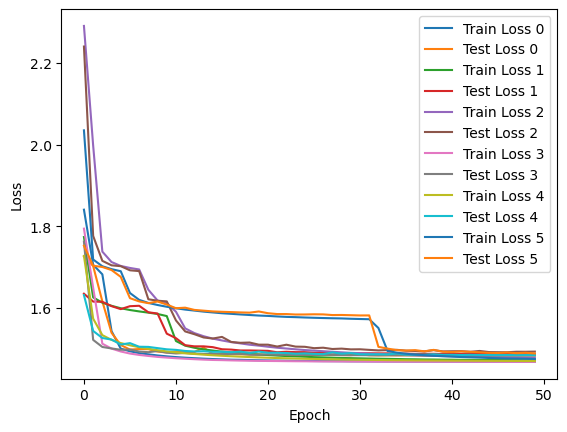

In [48]:
# 训练模型
## 初始化模型
net_list = [Net0(), Net1(), Net2(), Net3(), Net4(), Net5()]
train_loss_list = []
test_loss_list = []
for net in net_list:
    ## 设置训练轮数
    num_epochs = 50
    ## 设置学习率
    lr = 0.01
    ## 指定优化器为PyTorch自带的随机梯度下降
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    ## 初始化损失函数
    loss = nn.CrossEntropyLoss()

    # 开始训练
    train_loss, test_loss = train(net, train_iter, loss, num_epochs, lr, optimizer)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    
# 训练完成后将损失函数绘制在同一张图上
for i in range(len(net_list)):
    plt.plot(train_loss_list[i], label="Train Loss " + str(i))
    plt.plot(test_loss_list[i], label="Test Loss " + str(i))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [49]:
for i in test_loss_list:
    print(i[-1])

1.4827310532331466
1.4859572321176528
1.4923777252435684
1.4829082280397414
1.4836740702390672
1.4878322333097458


Task 5 在多分类任务实验中实现momentum、rmsprop、adam优化器

In [94]:
# 定义模型
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 定义模型参数
        num_inputs, num_outputs, num_hiddens = 784, 10, 256
        
        # 定义模型结构
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_inputs, num_hiddens),
            nn.LeakyReLU(),
            nn.Linear(num_hiddens, num_outputs),
        )
        
        # 初始化模型参数
        for layer in self.model:
            if isinstance(layer, nn.Linear):
                nn.init.normal_(layer.weight, mean=0, std=0.01)
                nn.init.zeros_(layer.bias)
    
    def forward(self, x):
        x = self.model(x)
        x = torch.softmax(x, dim=1)
        return x

In [86]:
# 定义训练函数
def train(net, train_iter, loss_func, num_epochs, lr=None, optimizer=None):
    train_loss_list = []
    test_loss_list = []
    net.to(device)
    for epoch in range(num_epochs):
        train_1_sum, train_acc_sum, n, c = 0.0, 0.0, 0, 0
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            loss = loss_func(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_1_sum += loss.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
            c += 1
        test_acc, test_loss = evaluate_accuracy(test_iter, net, loss_func)
        train_loss_list.append(train_1_sum / c)
        test_loss_list.append(test_loss)
        print('epoch %d, train loss %.4f, test loss %.4f, train acc %.3f, test acc %.3f' % (epoch + 1, train_1_sum / c, test_loss, train_acc_sum / n, test_acc))
    return train_loss_list, test_loss_list

In [97]:
train_loss_list = []
test_loss_list = []

In [98]:
# 训练模型
## 初始化模型
net = Net()
## 设置训练轮数
num_epochs = 50
## 设置学习率
lr = 0.01
## 指定优化器为SGD_momentum
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.5)
## 初始化损失函数
loss = nn.CrossEntropyLoss()

# 开始训练
train_loss, test_loss = train(net, train_iter, loss, num_epochs, lr, optimizer)
train_loss_list.append(train_loss)
test_loss_list.append(test_loss)

epoch 1, train loss 1.7229, test loss 1.6000, train acc 0.739, test acc 0.861
epoch 2, train loss 1.5434, test loss 1.5116, train acc 0.921, test acc 0.951
epoch 3, train loss 1.5024, test loss 1.5019, train acc 0.962, test acc 0.961
epoch 4, train loss 1.4935, test loss 1.4944, train acc 0.970, test acc 0.968
epoch 5, train loss 1.4883, test loss 1.4930, train acc 0.975, test acc 0.970
epoch 6, train loss 1.4846, test loss 1.4898, train acc 0.979, test acc 0.972
epoch 7, train loss 1.4811, test loss 1.4916, train acc 0.982, test acc 0.970
epoch 8, train loss 1.4791, test loss 1.4888, train acc 0.984, test acc 0.972
epoch 9, train loss 1.4773, test loss 1.4885, train acc 0.985, test acc 0.973
epoch 10, train loss 1.4757, test loss 1.4865, train acc 0.987, test acc 0.975
epoch 11, train loss 1.4744, test loss 1.4883, train acc 0.988, test acc 0.974
epoch 12, train loss 1.4732, test loss 1.4859, train acc 0.989, test acc 0.975
epoch 13, train loss 1.4720, test loss 1.4836, train acc 0.99

In [99]:
# 训练模型
## 初始化模型
net = Net()
## 设置训练轮数
num_epochs = 50
## 设置学习率
lr = 0.001
## 设置alpha
alpha = 0.9
## 指定优化器为RMSprop
optimizer = torch.optim.RMSprop(net.parameters(), lr=lr, alpha=alpha)
## 初始化损失函数
loss = nn.CrossEntropyLoss()

# 开始训练
train_loss, test_loss = train(net, train_iter, loss, num_epochs, lr, optimizer)
train_loss_list.append(train_loss)
test_loss_list.append(test_loss)

epoch 1, train loss 1.8700, test loss 1.6623, train acc 0.590, test acc 0.797
epoch 2, train loss 1.5629, test loss 1.5388, train acc 0.898, test acc 0.922
epoch 3, train loss 1.5347, test loss 1.5157, train acc 0.926, test acc 0.944
epoch 4, train loss 1.5219, test loss 1.5123, train acc 0.939, test acc 0.947
epoch 5, train loss 1.5185, test loss 1.5177, train acc 0.943, test acc 0.943
epoch 6, train loss 1.5145, test loss 1.5149, train acc 0.947, test acc 0.946
epoch 7, train loss 1.5145, test loss 1.5119, train acc 0.946, test acc 0.948
epoch 8, train loss 1.5100, test loss 1.5072, train acc 0.951, test acc 0.953
epoch 9, train loss 1.5076, test loss 1.5080, train acc 0.953, test acc 0.952
epoch 10, train loss 1.5078, test loss 1.5010, train acc 0.953, test acc 0.959
epoch 11, train loss 1.5086, test loss 1.5071, train acc 0.953, test acc 0.953
epoch 12, train loss 1.5056, test loss 1.5092, train acc 0.956, test acc 0.951
epoch 13, train loss 1.5045, test loss 1.5160, train acc 0.95

In [100]:
# 训练模型
## 初始化模型
net = Net()
## 设置训练轮数
num_epochs = 50
## 设置学习率
lr = 0.001
## 指定优化器为Adam
optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999))
loss = nn.CrossEntropyLoss()

# 开始训练
train_loss, test_loss = train(net, train_iter, loss, num_epochs, lr, optimizer)
train_loss_list.append(train_loss)
test_loss_list.append(test_loss)

epoch 1, train loss 1.8509, test loss 1.7156, train acc 0.608, test acc 0.743
epoch 2, train loss 1.6958, test loss 1.6927, train acc 0.765, test acc 0.767
epoch 3, train loss 1.6849, test loss 1.6219, train acc 0.775, test acc 0.838
epoch 4, train loss 1.6210, test loss 1.6088, train acc 0.839, test acc 0.851
epoch 5, train loss 1.6074, test loss 1.6051, train acc 0.853, test acc 0.855
epoch 6, train loss 1.6039, test loss 1.6129, train acc 0.857, test acc 0.848
epoch 7, train loss 1.6030, test loss 1.6056, train acc 0.858, test acc 0.853
epoch 8, train loss 1.5992, test loss 1.5973, train acc 0.862, test acc 0.862
epoch 9, train loss 1.5983, test loss 1.5965, train acc 0.862, test acc 0.863
epoch 10, train loss 1.5964, test loss 1.5984, train acc 0.864, test acc 0.861
epoch 11, train loss 1.5961, test loss 1.5960, train acc 0.865, test acc 0.863
epoch 12, train loss 1.5936, test loss 1.5916, train acc 0.867, test acc 0.868
epoch 13, train loss 1.5972, test loss 1.5938, train acc 0.86

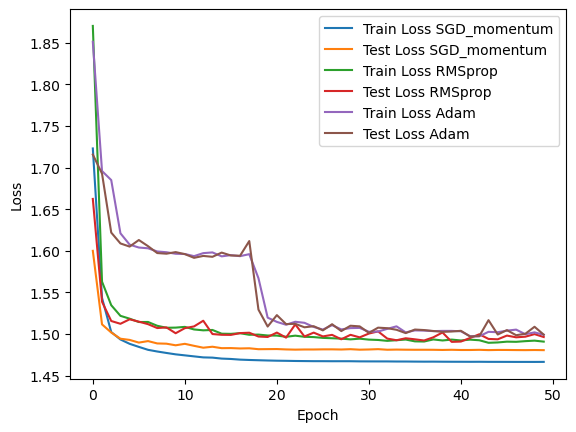

In [101]:
# 训练完成后将损失函数绘制在同一张图上
optimizer_list = ['SGD_momentum', 'RMSprop', 'Adam']
for i in range(len(optimizer_list)):
    plt.plot(train_loss_list[i], label="Train Loss " + optimizer_list[i])
    plt.plot(test_loss_list[i], label="Test Loss " + optimizer_list[i])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Task 6: 用torch.nn实现L2正则化，并在多分类任务中实验L2正则化对实验结果的影响

In [110]:
# 定义模型
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 定义模型参数
        num_inputs, num_outputs, num_hiddens = 784, 10, 256
        
        # 定义模型结构
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_inputs, num_hiddens),
            nn.ReLU(),
            nn.Linear(num_hiddens, num_outputs),
        )
        
        # 初始化模型参数
        for layer in self.model.parameters():
            nn.init.normal_(layer, mean=0, std=0.01)
    
    def forward(self, x):
        x = self.model(x)
        x = torch.softmax(x, dim=1)
        return x

In [111]:
# 定义训练函数
def train(net, train_iter, loss_func, num_epochs, lr=None, optimizer=None, weight_decay=0):
    train_loss_list = []
    test_loss_list = []
    net.to(device)
    for epoch in range(num_epochs):
        train_1_sum, train_acc_sum, n, c = 0.0, 0.0, 0, 0
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            loss = loss_func(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_1_sum += loss.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
            c += 1
        test_acc, test_loss = evaluate_accuracy(test_iter, net, loss_func)
        train_loss_list.append(train_1_sum / c)
        test_loss_list.append(test_loss)
        print('epoch %d, train loss %.4f, test loss %.4f, train acc %.3f, test acc %.3f' % (epoch + 1, train_1_sum / c, test_loss, train_acc_sum / n, test_acc))
    return train_loss_list, test_loss_list

In [112]:
train_loss_list = []
test_loss_list = []

In [113]:
# 无正则化
# 训练模型
## 初始化模型
net = Net()
## 设置训练轮数
num_epochs = 50
## 设置学习率
lr = 0.01
## 指定优化器为PyTorch自带的随机梯度下降
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
## 初始化损失函数
loss = nn.CrossEntropyLoss()

# 开始训练
train_loss, test_loss = train(net, train_iter, loss, num_epochs, lr, optimizer)
train_loss_list.append(train_loss)
test_loss_list.append(test_loss)

epoch 1, train loss 1.7088, test loss 1.5414, train acc 0.756, test acc 0.924
epoch 2, train loss 1.5247, test loss 1.5212, train acc 0.942, test acc 0.943
epoch 3, train loss 1.5078, test loss 1.5045, train acc 0.957, test acc 0.959
epoch 4, train loss 1.4988, test loss 1.5040, train acc 0.966, test acc 0.961
epoch 5, train loss 1.4934, test loss 1.4970, train acc 0.971, test acc 0.967
epoch 6, train loss 1.4891, test loss 1.5049, train acc 0.975, test acc 0.959
epoch 7, train loss 1.4857, test loss 1.4994, train acc 0.979, test acc 0.964
epoch 8, train loss 1.4832, test loss 1.4906, train acc 0.981, test acc 0.971
epoch 9, train loss 1.4804, test loss 1.4910, train acc 0.983, test acc 0.971
epoch 10, train loss 1.4788, test loss 1.4904, train acc 0.985, test acc 0.972
epoch 11, train loss 1.4776, test loss 1.4885, train acc 0.986, test acc 0.973
epoch 12, train loss 1.4764, test loss 1.4899, train acc 0.987, test acc 0.973
epoch 13, train loss 1.4754, test loss 1.4880, train acc 0.98

In [114]:
# 训练模型
## 初始化模型
net = Net()
## 设置训练轮数
num_epochs = 50
## 设置学习率
lr = 0.01
## 设置L2正则化参数
weight_decay = 0.01
## 指定优化器为PyTorch自带的随机梯度下降
optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=weight_decay)
## 初始化损失函数
loss = nn.CrossEntropyLoss()

# 开始训练
train_loss, test_loss = train(net, train_iter, loss, num_epochs, lr, optimizer, weight_decay)
train_loss_list.append(train_loss)
test_loss_list.append(test_loss)

epoch 1, train loss 1.8522, test loss 1.7054, train acc 0.608, test acc 0.754
epoch 2, train loss 1.6065, test loss 1.5232, train acc 0.859, test acc 0.944
epoch 3, train loss 1.5136, test loss 1.5269, train acc 0.953, test acc 0.939
epoch 4, train loss 1.5028, test loss 1.5046, train acc 0.963, test acc 0.961
epoch 5, train loss 1.4962, test loss 1.5018, train acc 0.969, test acc 0.963
epoch 6, train loss 1.4915, test loss 1.5226, train acc 0.974, test acc 0.943
epoch 7, train loss 1.4882, test loss 1.4947, train acc 0.977, test acc 0.969
epoch 8, train loss 1.4853, test loss 1.5003, train acc 0.980, test acc 0.964
epoch 9, train loss 1.4832, test loss 1.4909, train acc 0.982, test acc 0.973
epoch 10, train loss 1.4813, test loss 1.4918, train acc 0.983, test acc 0.972
epoch 11, train loss 1.4798, test loss 1.4907, train acc 0.985, test acc 0.973
epoch 12, train loss 1.4783, test loss 1.4884, train acc 0.986, test acc 0.975
epoch 13, train loss 1.4772, test loss 1.4874, train acc 0.98

In [115]:
# 修改L2正则化参数
# 训练模型
## 初始化模型
net = Net()
## 设置训练轮数
num_epochs = 50
## 设置学习率
lr = 0.01
## 设置L2正则化参数
weight_decay = 0.1
## 指定优化器为PyTorch自带的随机梯度下降
optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=weight_decay)
## 初始化损失函数
loss = nn.CrossEntropyLoss()

# 开始训练
train_loss, test_loss = train(net, train_iter, loss, num_epochs, lr, optimizer, weight_decay)
train_loss_list.append(train_loss)
test_loss_list.append(test_loss)

epoch 1, train loss 1.6358, test loss 1.5450, train acc 0.834, test acc 0.926
epoch 2, train loss 1.5275, test loss 1.5247, train acc 0.944, test acc 0.945
epoch 3, train loss 1.5150, test loss 1.5171, train acc 0.956, test acc 0.956
epoch 4, train loss 1.5087, test loss 1.5283, train acc 0.964, test acc 0.944
epoch 5, train loss 1.5064, test loss 1.5236, train acc 0.967, test acc 0.950
epoch 6, train loss 1.5039, test loss 1.5103, train acc 0.969, test acc 0.963
epoch 7, train loss 1.5013, test loss 1.5049, train acc 0.972, test acc 0.966
epoch 8, train loss 1.5009, test loss 1.5183, train acc 0.973, test acc 0.957
epoch 9, train loss 1.4994, test loss 1.5277, train acc 0.974, test acc 0.947
epoch 10, train loss 1.4993, test loss 1.5186, train acc 0.975, test acc 0.956
epoch 11, train loss 1.4984, test loss 1.5001, train acc 0.975, test acc 0.972
epoch 12, train loss 1.4976, test loss 1.4988, train acc 0.976, test acc 0.972
epoch 13, train loss 1.4985, test loss 1.4972, train acc 0.97

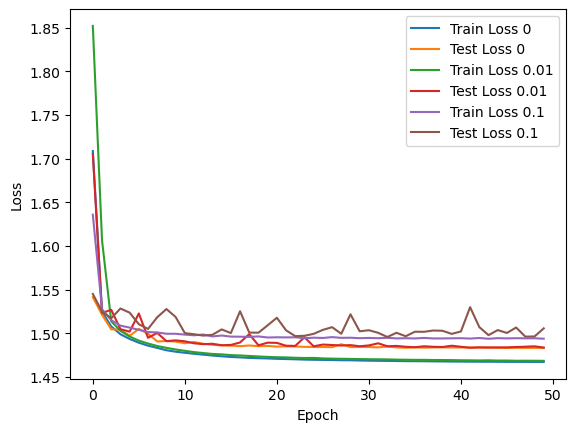

In [116]:
# 训练完成后将损失函数绘制在同一张图上
weight_decay_list = [0, 0.01, 0.1]
for i in range(len(weight_decay_list)):
    plt.plot(train_loss_list[i], label="Train Loss " + str(weight_decay_list[i]))
    plt.plot(test_loss_list[i], label="Test Loss " + str(weight_decay_list[i]))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

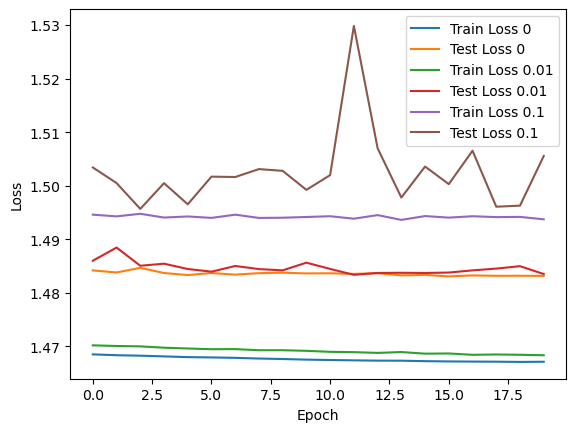

In [118]:
# 训练完成后将损失函数绘制在同一张图上，只显示后20个epoch
weight_decay_list = [0, 0.01, 0.1]
for i in range(len(weight_decay_list)):
    plt.plot(train_loss_list[i][30:], label="Train Loss " + str(weight_decay_list[i]))
    plt.plot(test_loss_list[i][30:], label="Test Loss " + str(weight_decay_list[i]))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Task 7: 在多分类任务中实现dropout，并实验dropout对实验结果的影响

In [143]:
# 定义模型
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 定义模型参数
        num_inputs, num_outputs, num_hiddens = 784, 10, 256
        
        # 定义模型结构
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_inputs, num_hiddens),
            nn.ReLU(),
            nn.Linear(num_hiddens, num_hiddens),
            nn.ReLU(),
            nn.Linear(num_hiddens, num_outputs),
        )
        
        # 初始化模型参数
        for layer in self.model.parameters():
            nn.init.normal_(layer, mean=0, std=0.01)
    
    def forward(self, x):
        x = self.model(x)
        x = torch.softmax(x, dim=1)
        return x

In [144]:
def evaluate_accuracy(data_iter, model, loss_func):
    acc_sum, test_1_sum, n, c = 0.0, 0.0, 0, 0
    model.eval()  # 切换到评估模式
    with torch.no_grad():  # 禁用梯度计算
        for X, y in data_iter:
            X, y = X.to(device), y.to(device)  # 将数据移动到GPU
            result = model.forward(X)
            acc_sum += (result.argmax(dim=1) == y).float().sum().item()
            test_1_sum += loss_func(result, y).item()
            n += y.shape[0]
            c += 1
    model.train()  # 切换回训练模式
    return acc_sum / n, test_1_sum / c

In [145]:
# 定义训练函数
def train(net, train_iter, loss_func, num_epochs, lr=None, optimizer=None):
    train_loss_list = []
    test_loss_list = []
    net.to(device)
    for epoch in range(num_epochs):
        train_1_sum, train_acc_sum, n, c = 0.0, 0.0, 0, 0
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            loss = loss_func(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_1_sum += loss.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
            c += 1
        test_acc, test_loss = evaluate_accuracy(test_iter, net, loss_func)
        train_loss_list.append(train_1_sum / c)
        test_loss_list.append(test_loss)
        print('epoch %d, train loss %.4f, test loss %.4f, train acc %.3f, test acc %.3f' % (epoch + 1, train_1_sum / c, test_loss, train_acc_sum / n, test_acc))
    return train_loss_list, test_loss_list

In [146]:
train_loss_list = []
test_loss_list = []

In [147]:
# 无dropout
# 训练模型
## 初始化模型
net = Net()
## 设置训练轮数
num_epochs = 50
## 设置学习率
lr = 0.01
## 指定优化器为PyTorch自带的随机梯度下降
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
## 初始化损失函数
loss = nn.CrossEntropyLoss()

# 开始训练
train_loss, test_loss = train(net, train_iter, loss, num_epochs, lr, optimizer)
train_loss_list.append(train_loss)
test_loss_list.append(test_loss)

epoch 1, train loss 1.7789, test loss 1.6407, train acc 0.722, test acc 0.829
epoch 2, train loss 1.6355, test loss 1.6227, train acc 0.833, test acc 0.841
epoch 3, train loss 1.6207, test loss 1.6186, train acc 0.845, test acc 0.845
epoch 4, train loss 1.6114, test loss 1.6107, train acc 0.854, test acc 0.851
epoch 5, train loss 1.6048, test loss 1.6026, train acc 0.859, test acc 0.859
epoch 6, train loss 1.5998, test loss 1.5997, train acc 0.864, test acc 0.861
epoch 7, train loss 1.5955, test loss 1.5953, train acc 0.868, test acc 0.866
epoch 8, train loss 1.5926, test loss 1.5931, train acc 0.870, test acc 0.867
epoch 9, train loss 1.5898, test loss 1.5951, train acc 0.873, test acc 0.866
epoch 10, train loss 1.5873, test loss 1.5888, train acc 0.875, test acc 0.872
epoch 11, train loss 1.5854, test loss 1.5893, train acc 0.877, test acc 0.870
epoch 12, train loss 1.5832, test loss 1.5870, train acc 0.879, test acc 0.873
epoch 13, train loss 1.5815, test loss 1.5863, train acc 0.88

In [148]:
# 定义模型
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 定义模型参数
        num_inputs, num_outputs, num_hiddens = 784, 10, 256
        
        # 定义模型结构
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_inputs, num_hiddens),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(num_hiddens, num_hiddens),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(num_hiddens, num_outputs),
        )
        
        # 初始化模型参数
        for layer in self.model.parameters():
            nn.init.normal_(layer, mean=0, std=0.01)
    
    def forward(self, x):
        x = self.model(x)
        x = torch.softmax(x, dim=1)
        return x

In [149]:
# dropout
# 训练模型
## 初始化模型
net = Net()
## 设置训练轮数
num_epochs = 50
## 设置学习率
lr = 0.01
## 指定优化器为PyTorch自带的随机梯度下降
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
## 初始化损失函数
loss = nn.CrossEntropyLoss()

# 开始训练
train_loss, test_loss = train(net, train_iter, loss, num_epochs, lr, optimizer)
train_loss_list.append(train_loss)
test_loss_list.append(test_loss)

epoch 1, train loss 1.9020, test loss 1.7125, train acc 0.583, test acc 0.753
epoch 2, train loss 1.7261, test loss 1.6487, train acc 0.743, test acc 0.817
epoch 3, train loss 1.6470, test loss 1.5607, train acc 0.826, test acc 0.908
epoch 4, train loss 1.5886, test loss 1.5401, train acc 0.884, test acc 0.926
epoch 5, train loss 1.5702, test loss 1.5325, train acc 0.899, test acc 0.932
epoch 6, train loss 1.5589, test loss 1.5250, train acc 0.909, test acc 0.940
epoch 7, train loss 1.5509, test loss 1.5181, train acc 0.916, test acc 0.944
epoch 8, train loss 1.5440, test loss 1.5158, train acc 0.923, test acc 0.947
epoch 9, train loss 1.5379, test loss 1.5126, train acc 0.928, test acc 0.949
epoch 10, train loss 1.5348, test loss 1.5093, train acc 0.931, test acc 0.953
epoch 11, train loss 1.5312, test loss 1.5080, train acc 0.934, test acc 0.953
epoch 12, train loss 1.5291, test loss 1.5055, train acc 0.936, test acc 0.956
epoch 13, train loss 1.5250, test loss 1.5033, train acc 0.94

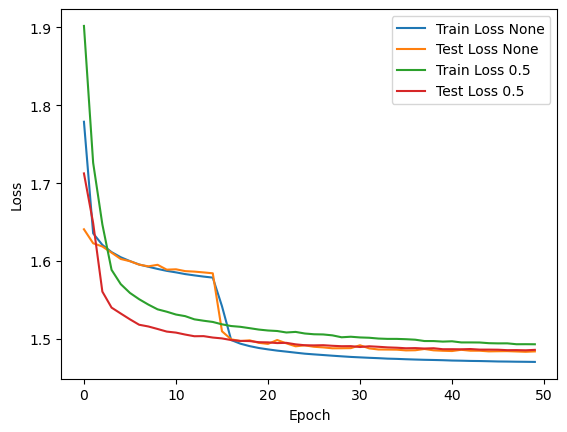

In [150]:
# 训练完成后将损失函数绘制在同一张图上
dropout_list = ['None', '0.5']
for i in range(len(dropout_list)):
    plt.plot(train_loss_list[i], label="Train Loss " + dropout_list[i])
    plt.plot(test_loss_list[i], label="Test Loss " + dropout_list[i])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

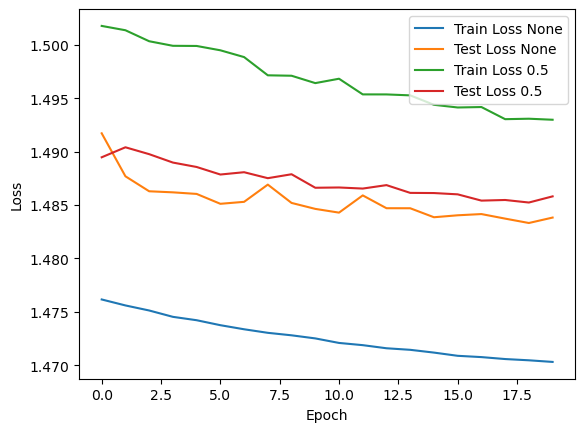

In [151]:
# 训练完成后将损失函数绘制在同一张图上，只显示后20个epoch
dropout_list = ['None', '0.5']
for i in range(len(dropout_list)):
    plt.plot(train_loss_list[i][30:], label="Train Loss " + dropout_list[i])
    plt.plot(test_loss_list[i][30:], label="Test Loss " + dropout_list[i])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Task 8: 实现早停机制，并在测试集上测试
训练集：验证集=8：2，早停轮数为5

In [155]:
# 定义模型
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 定义模型参数
        num_inputs, num_outputs, num_hiddens = 784, 10, 256
        
        # 定义模型结构
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_inputs, num_hiddens),
            nn.ReLU(),
            nn.Linear(num_hiddens, num_outputs),
        )
        
        # 初始化模型参数
        for layer in self.model.parameters():
            nn.init.normal_(layer, mean=0, std=0.01)
    
    def forward(self, x):
        x = self.model(x)
        x = torch.softmax(x, dim=1)
        return x

In [161]:
# 早停机制
# 定义训练函数
cnt = 0
def train(net, train_iter, test_iter, loss_func, num_epochs, lr=None, optimizer=None, early_stop=False):
    train_loss_list = []
    test_loss_list = []
    net.to(device)
    for epoch in range(num_epochs):
        train_1_sum, train_acc_sum, n, c = 0.0, 0.0, 0, 0
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            loss = loss_func(y_hat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_1_sum += loss.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
            c += 1
        test_acc, test_loss = evaluate_accuracy(test_iter, net, loss_func)
        train_loss_list.append(train_1_sum / c)
        test_loss_list.append(test_loss)
        print('epoch %d, train loss %.4f, test loss %.4f, train acc %.3f, test acc %.3f' % (epoch + 1, train_1_sum / c, test_loss, train_acc_sum / n, test_acc))
        # 早停轮数为5
        global cnt
        if early_stop:
            if len(test_loss_list) > 5:
                if test_loss_list[-1] > test_loss_list[-2] > test_loss_list[-3] > test_loss_list[-4] > test_loss_list[-5]:
                    cnt += 1
                    if cnt == 5:
                        break
                else:
                    cnt = 0
    return train_loss_list, test_loss_list

In [162]:
train_loss_list = []
test_loss_list = []

In [163]:
# 无早停机制
# 训练模型
## 初始化模型
net = Net()
## 设置训练轮数
num_epochs = 50
## 设置学习率
lr = 0.01
## 指定优化器为PyTorch自带的随机梯度下降
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
## 初始化损失函数
loss = nn.CrossEntropyLoss()

# 开始训练
train_loss, test_loss = train(net, train_iter, test_iter, loss, num_epochs, lr, optimizer)
train_loss_list.append(train_loss)
test_loss_list.append(test_loss)

epoch 1, train loss 1.7409, test loss 1.6158, train acc 0.723, test acc 0.849
epoch 2, train loss 1.6116, test loss 1.6125, train acc 0.852, test acc 0.850
epoch 3, train loss 1.5975, test loss 1.6038, train acc 0.866, test acc 0.860
epoch 4, train loss 1.5894, test loss 1.5934, train acc 0.873, test acc 0.868
epoch 5, train loss 1.5840, test loss 1.5893, train acc 0.879, test acc 0.871
epoch 6, train loss 1.5107, test loss 1.4987, train acc 0.955, test acc 0.964
epoch 7, train loss 1.4907, test loss 1.5007, train acc 0.975, test acc 0.963
epoch 8, train loss 1.4865, test loss 1.4978, train acc 0.978, test acc 0.966
epoch 9, train loss 1.4835, test loss 1.4914, train acc 0.981, test acc 0.971
epoch 10, train loss 1.4812, test loss 1.4941, train acc 0.983, test acc 0.968
epoch 11, train loss 1.4793, test loss 1.4915, train acc 0.985, test acc 0.972
epoch 12, train loss 1.4776, test loss 1.4885, train acc 0.986, test acc 0.974
epoch 13, train loss 1.4765, test loss 1.4888, train acc 0.98

In [164]:
# 早停机制
# 训练模型
## 初始化模型
net = Net()
## 设置训练轮数
num_epochs = 50
## 设置学习率
lr = 0.01
## 指定优化器为PyTorch自带的随机梯度下降
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
## 初始化损失函数
loss = nn.CrossEntropyLoss()

# 开始训练
train_loss, test_loss = train(net, train_iter, test_iter, loss, num_epochs, lr, optimizer, early_stop=True)
train_loss_list.append(train_loss)
test_loss_list.append(test_loss)

epoch 1, train loss 1.6781, test loss 1.5898, train acc 0.789, test acc 0.875
epoch 2, train loss 1.5242, test loss 1.5186, train acc 0.942, test acc 0.946
epoch 3, train loss 1.5083, test loss 1.5236, train acc 0.958, test acc 0.940
epoch 4, train loss 1.4999, test loss 1.5026, train acc 0.965, test acc 0.961
epoch 5, train loss 1.4939, test loss 1.5001, train acc 0.971, test acc 0.964
epoch 6, train loss 1.4900, test loss 1.4991, train acc 0.974, test acc 0.964
epoch 7, train loss 1.4864, test loss 1.4928, train acc 0.978, test acc 0.970
epoch 8, train loss 1.4837, test loss 1.4922, train acc 0.980, test acc 0.972
epoch 9, train loss 1.4813, test loss 1.4922, train acc 0.983, test acc 0.970
epoch 10, train loss 1.4793, test loss 1.4899, train acc 0.985, test acc 0.973
epoch 11, train loss 1.4777, test loss 1.4880, train acc 0.986, test acc 0.974
epoch 12, train loss 1.4765, test loss 1.5047, train acc 0.987, test acc 0.957
epoch 13, train loss 1.4756, test loss 1.4871, train acc 0.98

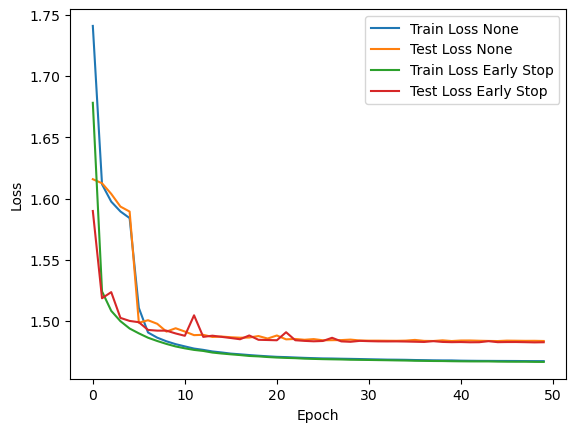

In [165]:
# 训练完成后将损失函数绘制在同一张图上
early_stop_list = ['None', 'Early Stop']
for i in range(len(early_stop_list)):
    plt.plot(train_loss_list[i], label="Train Loss " + early_stop_list[i])
    plt.plot(test_loss_list[i], label="Test Loss " + early_stop_list[i])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()